# Определение перспективного тарифа для телеком компании
## Описание проекта
Вы аналитик компании «Мегалайн» — федерального оператора сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.
Вам предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В вашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. **Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.**  
## Описание тарифов
### Тариф «Смарт»
1. Ежемесячная плата: 550 рублей
2. Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
3. Стоимость услуг сверх тарифного пакета:
    * минута разговора: 3 рубля
    * сообщение: 3 рубля
    * 1 Гб интернет-трафика: 200 рублей  
    
### Тариф «Ультра»
1. Ежемесячная плата: 1950 рублей
2. Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
3. Стоимость услуг сверх тарифного пакета:
    * минута разговора: 1 рубль
    * сообщение: 1 рубль
    * 1 Гб интернет-трафика: 150 рублей  
    
### Внимание:
«Мегалайн» всегда округляет вверх значения минут и мегабайтов. Если пользователь проговорил всего 1 секунду, в тарифе засчитывается целая минута.  

### Описание данных
#### Таблица users (информация о пользователях):
* user_id — уникальный идентификатор пользователя
* first_name — имя пользователя
* last_name — фамилия пользователя
* age — возраст пользователя (годы)
* reg_date — дата подключения тарифа (день, месяц, год)
* churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
* city — город проживания пользователя
* tariff — название тарифного плана  

#### Таблица calls (информация о звонках):
* id — уникальный номер звонка
* call_date — дата звонка
* duration — длительность звонка в минутах
* user_id — идентификатор пользователя, сделавшего звонок  

#### Таблица messages (информация о сообщениях):
* id — уникальный номер сообщения
* message_date — дата сообщения
* user_id — идентификатор пользователя, отправившего сообщение  

#### Таблица internet (информация об интернет-сессиях):
* id — уникальный номер сессии
* mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)
* session_date — дата интернет-сессии
* user_id — идентификатор пользователя  

#### Таблица tariffs (информация о тарифах):
* tariff_name — название тарифа
* rub_monthly_fee — ежемесячная абонентская плата в рублях
* minutes_included — количество минут разговора в месяц, включённых в абонентскую плату
* messages_included — количество сообщений в месяц, включённых в абонентскую плату
* mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
* rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
* rub_per_message — стоимость отправки сообщения сверх тарифного пакета
* rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)  
  
### Оглавление:
1. [Открытие файла с данными изучение общей информации](#1)  
2. [Подготовка данных](#2)  
    2.1. [Предобработка данных](#2.1)  
    2.2. [Подсчет значений](#2.2)
3. [Анализ данных](#3)  
    3.1 [Количество абонентов на тарифных планах](#3.1)  
    3.2 [Активность абонентов на тарифных планах](#3.2)  
    3.3 [Расчет среднего количества, дисперсии и стандартного отклонения](#3.3)
4. [Проверка гипотез](#4)
5. [Общий вывод](#5)


<a id="1"></a>
### 1. Открытие файла с данными изучение общей информации

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import pylab
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import warnings
warnings.filterwarnings("ignore") 
from scipy import stats as st
import math as mt

In [2]:
users = pd.read_csv("users.csv", parse_dates=["reg_date", "churn_date"])
users

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaT,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaT,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaT,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaT,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra
...,...,...,...,...,...,...,...,...
495,1495,65,NaT,Иркутск,Авксентий,Фокин,2018-08-28,ultra
496,1496,36,NaT,Вологда,Трифон,Блохин,2018-01-27,smart
497,1497,32,NaT,Челябинск,Каролина,Агеева,2018-10-09,smart
498,1498,68,2018-10-25,Владикавказ,Всеволод,Акимчин,2018-07-19,smart


In [3]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null datetime64[ns]
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null datetime64[ns]
tariff        500 non-null object
dtypes: datetime64[ns](2), int64(2), object(4)
memory usage: 31.4+ KB


In [4]:
calls = pd.read_csv("calls.csv", parse_dates=["call_date"])
calls

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000
...,...,...,...,...
202602,1499_215,2018-12-26,0.76,1499
202603,1499_216,2018-10-18,18.83,1499
202604,1499_217,2018-11-10,10.81,1499
202605,1499_218,2018-10-06,4.27,1499


In [5]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null datetime64[ns]
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 6.2+ MB


In [6]:
messages = pd.read_csv("messages.csv", parse_dates=["message_date"])
messages

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000
...,...,...,...
123031,1499_179,2018-12-12,1499
123032,1499_180,2018-09-28,1499
123033,1499_181,2018-09-27,1499
123034,1499_182,2018-11-15,1499


In [7]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null datetime64[ns]
user_id         123036 non-null int64
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 2.8+ MB


In [8]:
internet = pd.read_csv("internet.csv", parse_dates=["session_date"], index_col=0)
internet

,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000
...,...,...,...,...
149391,1499_152,318.90,2018-10-03,1499
149392,1499_153,490.13,2018-12-14,1499
149393,1499_154,0.00,2018-10-27,1499
149394,1499_155,1246.32,2018-11-26,1499


In [9]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149396 entries, 0 to 149395
Data columns (total 4 columns):
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null datetime64[ns]
user_id         149396 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 5.7+ MB


In [10]:
tariffs = pd.read_csv("tariffs.csv")
tariffs

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


<a id="2"></a>
### 2. Подготовка данных

<a id="2.1"></a>
#### 2.1 Предобработка данных

In [11]:
calls["duration"] = calls["duration"].apply(np.ceil)
calls["duration"] = calls["duration"].astype("int")
calls

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0,1000
1,1000_1,2018-08-17,0,1000
2,1000_2,2018-06-11,3,1000
3,1000_3,2018-09-21,14,1000
4,1000_4,2018-12-15,6,1000
...,...,...,...,...
202602,1499_215,2018-12-26,1,1499
202603,1499_216,2018-10-18,19,1499
202604,1499_217,2018-11-10,11,1499
202605,1499_218,2018-10-06,5,1499


In [12]:
internet["mb_used"] = internet["mb_used"].apply(np.ceil)
internet["mb_used"] = internet["mb_used"].astype("int")
internet

,id,mb_used,session_date,user_id
0,1000_0,113,2018-11-25,1000
1,1000_1,1053,2018-09-07,1000
2,1000_2,1198,2018-06-25,1000
3,1000_3,551,2018-08-22,1000
4,1000_4,303,2018-09-24,1000
...,...,...,...,...
149391,1499_152,319,2018-10-03,1499
149392,1499_153,491,2018-12-14,1499
149393,1499_154,0,2018-10-27,1499
149394,1499_155,1247,2018-11-26,1499


In [13]:
internet["gb_used"] = internet["mb_used"] / 1024
internet

,id,mb_used,session_date,user_id,gb_used
0,1000_0,113,2018-11-25,1000,0.110352
1,1000_1,1053,2018-09-07,1000,1.028320
2,1000_2,1198,2018-06-25,1000,1.169922
3,1000_3,551,2018-08-22,1000,0.538086
4,1000_4,303,2018-09-24,1000,0.295898
...,...,...,...,...,...
149391,1499_152,319,2018-10-03,1499,0.311523
149392,1499_153,491,2018-12-14,1499,0.479492
149393,1499_154,0,2018-10-27,1499,0.000000
149394,1499_155,1247,2018-11-26,1499,1.217773


<a id="2.2"></a>
#### 2.2 Подсчет значений

In [63]:
calls_fin = calls[calls.duration > 0].groupby(['user_id', pd.Grouper(key="call_date", freq="M")])\
    .agg({'id': 'count', 'duration': 'sum'}).reset_index()
calls_fin.columns = ["user_id", "date", "call_count", "ring_length"]
calls_fin

,user_id,date,call_count,ring_length
0,1000,2018-05-31,17,159
1,1000,2018-06-30,28,172
2,1000,2018-07-31,41,340
3,1000,2018-08-31,42,408
4,1000,2018-09-30,46,466
...,...,...,...,...
3163,1498,2018-10-31,30,247
3164,1499,2018-09-30,8,70
3165,1499,2018-10-31,44,449
3166,1499,2018-11-30,62,612


In [64]:
# Комментарий от ревьюера 2

calls[calls.duration > 0].groupby(['user_id', calls.call_date.dt.month]).agg({'id': 'count', 'duration': 'sum'}).reset_index()

,user_id,call_date,id,duration
0,1000,5,17,159
1,1000,6,28,172
2,1000,7,41,340
3,1000,8,42,408
4,1000,9,46,466
...,...,...,...,...
3163,1498,10,30,247
3164,1499,9,8,70
3165,1499,10,44,449
3166,1499,11,62,612


In [65]:
messages_fin = messages.groupby(['user_id', pd.Grouper(key="message_date", freq="M")])\
    .agg({'id': 'count'}).reset_index()
messages_fin.columns = ["user_id", "date", "message_count"]
messages_fin

,user_id,date,message_count
0,1000,2018-05-31,22
1,1000,2018-06-30,60
2,1000,2018-07-31,75
3,1000,2018-08-31,81
4,1000,2018-09-30,57
...,...,...,...
2712,1498,2018-10-31,42
2713,1499,2018-09-30,11
2714,1499,2018-10-31,48
2715,1499,2018-11-30,59


In [66]:
internet_fin = internet.groupby(['user_id', pd.Grouper(key="session_date", freq="M")])\
    .agg({'gb_used': 'sum'}).reset_index()
internet_fin.columns = ["user_id", "date", "gb_count"]
internet_fin

,user_id,date,gb_count
0,1000,2018-05-31,2.203125
1,1000,2018-06-30,22.711914
2,1000,2018-07-31,13.687500
3,1000,2018-08-31,13.740234
4,1000,2018-09-30,14.239258
...,...,...,...
3198,1498,2018-10-31,20.121094
3199,1499,2018-09-30,1.804688
3200,1499,2018-10-31,17.391602
3201,1499,2018-11-30,17.562500


In [67]:
calls_messege = pd.merge(calls_fin, messages_fin, on = ['user_id', 'date'], how="left")
calls_messege

,user_id,date,call_count,ring_length,message_count
0,1000,2018-05-31,17,159,22.0
1,1000,2018-06-30,28,172,60.0
2,1000,2018-07-31,41,340,75.0
3,1000,2018-08-31,42,408,81.0
4,1000,2018-09-30,46,466,57.0
...,...,...,...,...,...
3163,1498,2018-10-31,30,247,42.0
3164,1499,2018-09-30,8,70,11.0
3165,1499,2018-10-31,44,449,48.0
3166,1499,2018-11-30,62,612,59.0


In [68]:
calls_messege_internet = pd.merge(calls_messege, internet_fin, on = ['user_id', 'date'], how="right")
calls_messege_internet

,user_id,date,call_count,ring_length,message_count,gb_count
0,1000,2018-05-31,17.0,159.0,22.0,2.203125
1,1000,2018-06-30,28.0,172.0,60.0,22.711914
2,1000,2018-07-31,41.0,340.0,75.0,13.687500
3,1000,2018-08-31,42.0,408.0,81.0,13.740234
4,1000,2018-09-30,46.0,466.0,57.0,14.239258
...,...,...,...,...,...,...
3198,1489,2018-08-31,NaN,NaN,NaN,10.806641
3199,1489,2018-09-30,NaN,NaN,NaN,16.828125
3200,1489,2018-10-31,NaN,NaN,NaN,19.128906
3201,1489,2018-11-30,NaN,NaN,NaN,17.105469


In [69]:
df = pd.merge(users, calls_messege_internet, on = ['user_id'], how="outer")
df["gb_count"] = df["gb_count"].apply(np.ceil)
df

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,date,call_count,ring_length,message_count,gb_count
0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,2018-05-31,17.0,159.0,22.0,3.0
1,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,2018-06-30,28.0,172.0,60.0,23.0
2,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,2018-07-31,41.0,340.0,75.0,14.0
3,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,2018-08-31,42.0,408.0,81.0,14.0
4,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,2018-09-30,46.0,466.0,57.0,15.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3201,1498,68,2018-10-25,Владикавказ,Всеволод,Акимчин,2018-07-19,smart,2018-10-31,30.0,247.0,42.0,21.0
3202,1499,35,NaT,Пермь,Гектор,Корнилов,2018-09-27,smart,2018-09-30,8.0,70.0,11.0,2.0
3203,1499,35,NaT,Пермь,Гектор,Корнилов,2018-09-27,smart,2018-10-31,44.0,449.0,48.0,18.0
3204,1499,35,NaT,Пермь,Гектор,Корнилов,2018-09-27,smart,2018-11-30,62.0,612.0,59.0,18.0


In [99]:
# создам новый датафрейм с полным соединением таблиц
some_dataframe = pd.merge(calls_fin, messages_fin, how="outer", on = ['user_id', 'date'])  
some_dataframe = pd.merge(some_dataframe, internet_fin, how="outer", on = ['user_id', 'date'])  
some_dataframe = pd.merge(users, some_dataframe, how="outer", on = ['user_id'])

print(calls.duration.sum(), "- количество минут в таблице calls")
print(messages.shape[0], '- количество сообщений в таблице messages')
print(internet.gb_used.apply(np.ceil).sum(), '- количество Гб в таблице internet')

print('-'*40)

print(df.ring_length.sum(), '- общее количество минут в твоей таблице')
print(some_dataframe.ring_length.sum(), '- сколько может быть')

print('-'*40)

print(df.message_count.sum(), '- общее количество сообщений в твоей таблице')
print(some_dataframe.message_count.sum(), '- сколько может быть')

print('-'*40)

print(df.gb_count.sum(), '- общее количество Гб в твоей таблице')
print(some_dataframe.gb_count.apply(np.ceil).sum(), '- сколько может быть')

print('-'*40)

print(df.shape, 'размер твоей таблицы')
print(some_dataframe.shape, 'какой размер может быть')


1450301 - количество минут в таблице calls
123036 - количество сообщений в таблице messages
132142.0 - количество Гб в таблице internet
----------------------------------------
1448033.0 - общее количество минут в твоей таблице
1450301.0 - сколько может быть
----------------------------------------
120061.0 - общее количество сообщений в твоей таблице
123036.0 - сколько может быть
----------------------------------------
55698.0 - общее количество Гб в твоей таблице
55698.0 - сколько может быть
----------------------------------------
(3206, 13) размер твоей таблицы
(3216, 13) какой размер может быть


In [97]:
set(some_dataframe.user_id + some_dataframe.date) - set(df.user_id + df.date)

{Timestamp('2018-02-28 00:00:00.000001377'),
 Timestamp('2018-02-28 00:00:00.000001392'),
 Timestamp('2018-05-31 00:00:00.000001273'),
 Timestamp('2018-06-30 00:00:00.000001273'),
 Timestamp('2018-07-31 00:00:00.000001273'),
 Timestamp('2018-08-31 00:00:00.000001273'),
 Timestamp('2018-08-31 00:00:00.000001446'),
 Timestamp('2018-09-30 00:00:00.000001273'),
 Timestamp('2018-10-31 00:00:00.000001273'),
 Timestamp('2018-11-30 00:00:00.000001273'),
 Timestamp('2018-12-31 00:00:00.000001273')}

In [98]:
some_dataframe.query('user_id == "1377" and date == "2018-02-28"')

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,date,call_count,ring_length,message_count,gb_count,check
2389,1377,59,NaT,Брянск,Альфред,Семин,2018-02-25,ultra,2018-02-28,20.0,179.0,2.0,NaN,2018-02-28 00:00:00.000001377


In [22]:
df.isnull().sum()

user_id             0
age                 0
churn_date       3018
city                0
first_name          0
last_name           0
reg_date            0
tariff              0
date                3
call_count         49
ring_length        49
message_count     544
gb_count            3
dtype: int64

In [23]:
df["message_count"] = df["message_count"].fillna(0)
df["gb_count"] = df["gb_count"].fillna(0)
df["ring_length"] = df["ring_length"].fillna(0)
df["call_count"] = df["call_count"].fillna(0)

In [24]:
def func_tariff(row):
    
    if row["tariff"] == "smart" and row["ring_length"] > 500 and row["message_count"] > 50 and row["gb_count"] > 15:
        return ((row["ring_length"] - 500) * 3) + ((row["message_count"] - 50) * 3) \
                    + ((row["gb_count"] - 15) * 200) + 550
    
    if row["tariff"] == "smart" and row["ring_length"] > 500 and row["message_count"] > 50 and row["gb_count"] <= 15:
        return ((row["ring_length"] - 500) * 3) + ((row["message_count"] - 50) * 3) + 550
    
    if row["tariff"] == "smart" and row["ring_length"] > 500 and row["message_count"] <= 50 and row["gb_count"] > 15:
        return ((row["ring_length"] - 500) * 3) + ((row["gb_count"] - 15) * 200) + 550
    
    if row["tariff"] == "smart" and row["ring_length"] > 500 and row["message_count"] <= 50 and row["gb_count"] <= 15:
        return ((row["ring_length"] - 500) * 3) + 550
    
    if row["tariff"] == "smart" and row["ring_length"] <= 500 and row["message_count"] > 50 and row["gb_count"] > 15:
        return ((row["message_count"] - 50) * 3) + ((row["gb_count"] - 15) * 200) + 550
    
    if row["tariff"] == "smart" and row["ring_length"] <= 500 and row["message_count"] > 50 and row["gb_count"] <= 15:
        return ((row["message_count"] - 50) * 3) + 550
    
    if row["tariff"] == "smart" and row["ring_length"] <= 500 and row["message_count"] <= 50 and row["gb_count"] > 15:
        return ((row["gb_count"] - 15) * 200) + 550 
        
    if row["tariff"] == "smart" and row["ring_length"] <= 500 and row["message_count"] <= 50 and row["gb_count"] <= 15:
        return 550
    
    
    
    if row["tariff"] == "ultra" and row["ring_length"] > 3000 and row["message_count"] > 1000 and row["gb_count"] > 30:
        return ((row["ring_length"] - 3000) * 1) + ((row["message_count"] - 1000) * 1) \
                    + ((row["gb_count"] - 30) * 150) + 1950
    
    if row["tariff"] == "ultra" and row["ring_length"] > 3000 and row["message_count"] > 1000 and row["gb_count"] <= 30:
        return ((row["ring_length"] - 3000) * 1) + ((row["message_count"] - 1000) * 1) + 1950
    
    if row["tariff"] == "ultra" and row["ring_length"] > 3000 and row["message_count"] <= 1000 and row["gb_count"] > 30:
        return ((row["ring_length"] - 3000) * 1) + ((row["gb_count"] - 30) * 150) + 1950
    
    if row["tariff"] == "ultra" and row["ring_length"] > 3000 and row["message_count"] <= 1000 and row["gb_count"] <= 30:
        return ((row["ring_length"] - 3000) * 1) + 1950
    
    if row["tariff"] == "ultra" and row["ring_length"] <= 3000 and row["message_count"] > 1000 and row["gb_count"] > 30:
        return ((row["message_count"] - 1000) * 1) + ((row["gb_count"] - 30) * 150) + 1950
    
    if row["tariff"] == "ultra" and row["ring_length"] <= 3000 and row["message_count"] > 1000 and row["gb_count"] <= 30:
        return ((row["message_count"] - 1000) * 1) + 1950
    
    if row["tariff"] == "ultra" and row["ring_length"] <= 3000 and row["message_count"] <= 1000 and row["gb_count"] > 30:
        return ((row["gb_count"] - 30) * 150) + 1950 
        
    if row["tariff"] == "ultra" and row["ring_length"] <= 3000 and row["message_count"] <= 1000 and row["gb_count"] <= 30:
        return 1950
       

In [25]:
df["price"] = df.apply(func_tariff, axis=1)
df

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,date,call_count,ring_length,message_count,gb_count,price
0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,2018-05-31,17.0,159.0,22.0,3.0,1950.0
1,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,2018-06-30,28.0,172.0,60.0,23.0,1950.0
2,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,2018-07-31,41.0,340.0,75.0,14.0,1950.0
3,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,2018-08-31,42.0,408.0,81.0,14.0,1950.0
4,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,2018-09-30,46.0,466.0,57.0,15.0,1950.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3201,1498,68,2018-10-25,Владикавказ,Всеволод,Акимчин,2018-07-19,smart,2018-10-31,30.0,247.0,42.0,21.0,1750.0
3202,1499,35,NaT,Пермь,Гектор,Корнилов,2018-09-27,smart,2018-09-30,8.0,70.0,11.0,2.0,550.0
3203,1499,35,NaT,Пермь,Гектор,Корнилов,2018-09-27,smart,2018-10-31,44.0,449.0,48.0,18.0,1150.0
3204,1499,35,NaT,Пермь,Гектор,Корнилов,2018-09-27,smart,2018-11-30,62.0,612.0,59.0,18.0,1513.0


##### Вывод
> Получили новый датафрем с выборкой данных по интересующиму нас оператору и двум тарифным планам. Датафрем имеет 3203 строки, 14 столбцов. Все пропущенные значения были заменены на те что соответствуют информации представленной в колонке где они отсутствуют, типы данных приведены в соответстви с данными. Данные готовы для дальнейшего анализа

<a id="3"></a>
### 3. Анализ данных

<a id="3.1"></a>
#### 3.1 Количество абонентов на тарифных планах

In [26]:
df_1 = df.groupby("tariff")["user_id"].count().reset_index()
df_1

,tariff,user_id
0,smart,2229
1,ultra,977


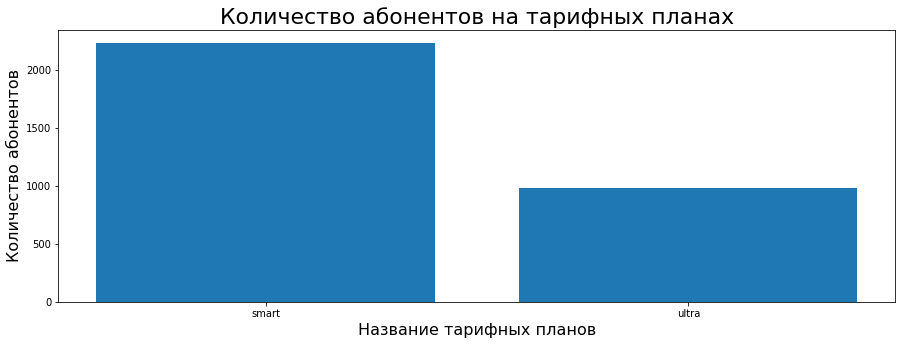

In [27]:
plt.figure(figsize=(15, 5))
plt.bar(df_1.tariff.values, df_1.user_id.values)
plt.title("Количество абонентов на тарифных планах", fontsize=22)
plt.xlabel("Название тарифных планов", fontsize=16)
plt.ylabel("Количество абонентов", fontsize=16)
plt.show()

<a id="3.2"></a>
#### 3.2 Активность абонентов на тарифных планах

In [28]:
df_smart = df[df.tariff == "smart"].groupby("date")["ring_length", "message_count", "gb_count", "price"].mean()
df_smart

,ring_length,message_count,gb_count,price
date,,,,
2018-01-31,203.852941,17.411765,8.735294,721.323529
2018-02-28,298.689655,24.086207,11.844828,827.603448
2018-03-31,390.051948,31.857143,15.246753,1164.623377
2018-04-30,367.133929,30.312500,13.642857,963.089286
2018-05-31,387.361702,33.773050,15.943262,1204.602837
2018-06-30,395.640244,33.109756,15.981707,1208.896341
2018-07-31,408.353234,33.751244,15.910448,1228.925373
2018-08-31,423.055556,33.705128,16.854701,1332.435897
2018-09-30,428.611538,33.515385,16.423077,1255.330769


In [29]:
df_ultra = df[df.tariff == "ultra"].groupby("date")["ring_length", "message_count", "gb_count", "price"].mean()
df_ultra

,ring_length,message_count,gb_count,price
date,,,,
2018-01-31,428.111111,33.777778,13.333333,1950.000000
2018-02-28,315.409091,23.727273,13.090909,1977.272727
2018-03-31,489.648649,32.297297,17.702703,2014.864865
2018-04-30,458.018182,31.400000,17.000000,2001.818182
2018-05-31,514.727273,36.393939,19.727273,2063.636364
2018-06-30,482.710843,38.626506,19.192771,2042.168675
2018-07-31,549.044444,45.366667,20.766667,2123.333333
2018-08-31,513.207547,44.641509,19.820755,2084.433962
2018-09-30,542.219298,48.824561,19.421053,2025.000000


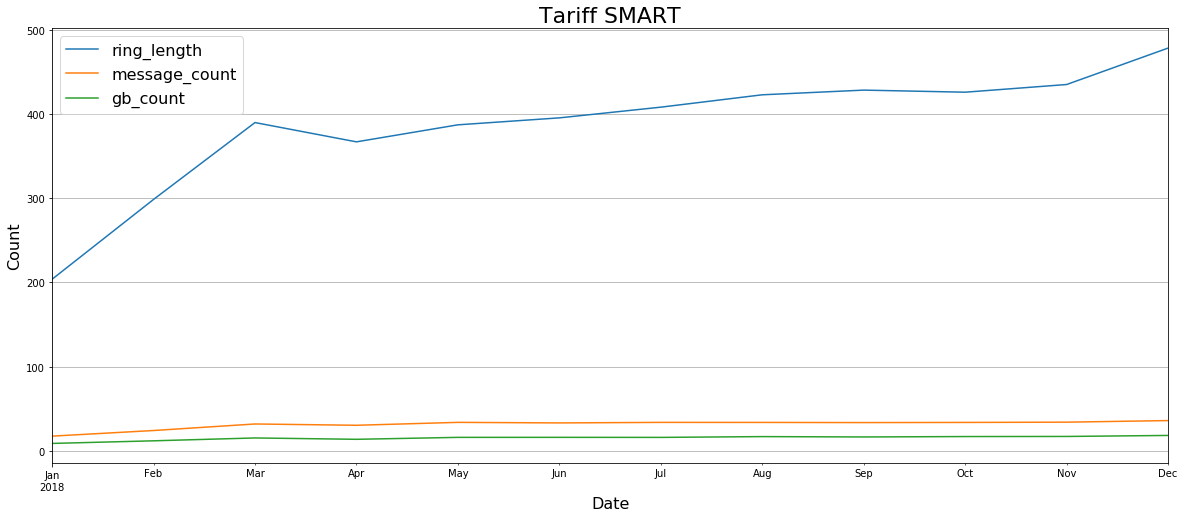

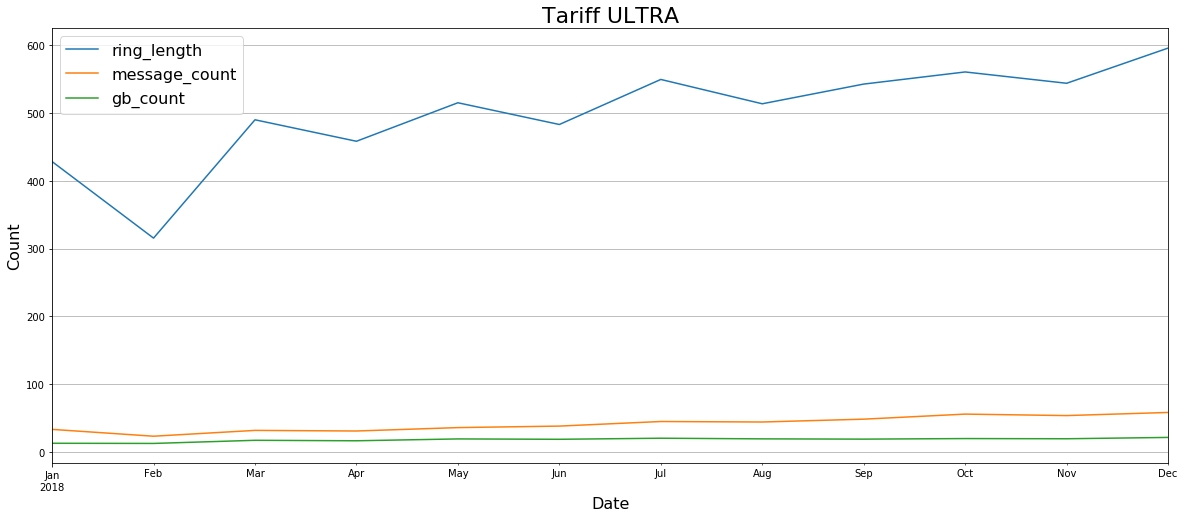

In [30]:
df_smart[["ring_length", "message_count", "gb_count"]].plot(figsize=(20,8))
plt.title("Tariff SMART", fontsize=22)
plt.xlabel("Date", fontsize=16)
plt.ylabel("Count", fontsize=16)
plt.legend(fontsize=16)
plt.grid()
plt.show()

df_ultra[["ring_length", "message_count", "gb_count"]].plot(figsize=(20,8))
plt.title("Tariff ULTRA", fontsize=22)
plt.xlabel("Date", fontsize=16)
plt.ylabel("Count", fontsize=16)
plt.legend(fontsize=16)
plt.grid()
plt.show()

<a id="3.3"></a>
#### 3.3  Расчет среднего количества, дисперсии и стандартного отклонения

In [31]:
np.var(df_smart, ddof=1)

ring_length       5232.024911
message_count       27.858154
gb_count             6.986231
price            58234.273977
dtype: float64

In [32]:
np.std(df_smart, ddof=1)

ring_length       72.332737
message_count      5.278082
gb_count           2.643148
price            241.317786
dtype: float64

In [33]:
df_smart.mean() + 3 * np.std(df_smart, ddof=1)

ring_length       603.891000
message_count      47.094157
gb_count           23.159227
price            1907.837510
dtype: float64

In [34]:
df_smart.mean() - 3 * np.std(df_smart, ddof=1)

ring_length      169.894575
message_count     15.425663
gb_count           7.300339
price            459.930792
dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f97744f5b10>,
      dtype=object)

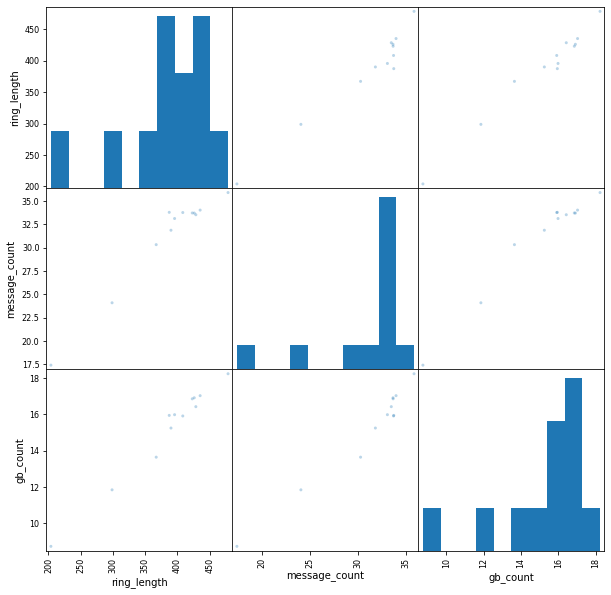

In [35]:
pd.plotting.scatter_matrix(df_smart[['ring_length', 'message_count', 'gb_count']], alpha = 0.3, figsize = (10,10))

In [36]:
np.var(df_ultra, ddof=1)

ring_length      5503.926605
message_count     122.244643
gb_count            7.787084
price            3335.892930
dtype: float64

In [37]:
np.std(df_ultra, ddof=1)

ring_length      74.188453
message_count    11.056430
gb_count          2.790535
price            57.757189
dtype: float64

In [38]:
df_ultra.mean() + 3 * np.std(df_ultra, ddof=1)

ring_length       721.881495
message_count      75.179766
gb_count           26.890690
price            2222.033167
dtype: float64

In [39]:
df_ultra.mean() - 3 * np.std(df_ultra, ddof=1)

ring_length       276.750775
message_count       8.841186
gb_count           10.147482
price            1875.490031
dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9774522b90>,
      dtype=object)

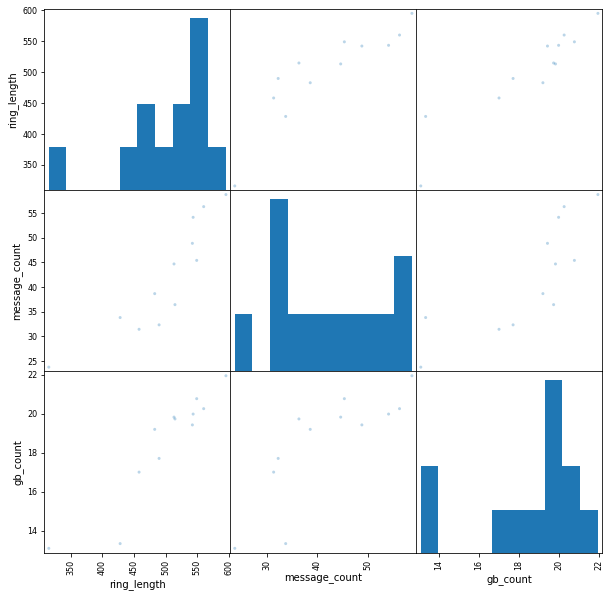

In [40]:
pd.plotting.scatter_matrix(df_ultra[['ring_length', 'message_count', 'gb_count']], alpha = 0.3, figsize = (10,10))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f976a479950>]],
      dtype=object)

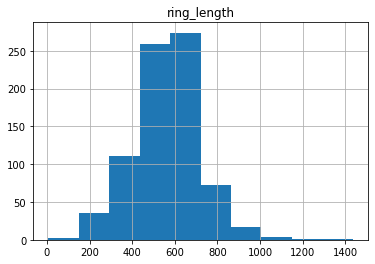

In [41]:
df.pivot_table(index="price", values="ring_length").hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f976a41e290>]],
      dtype=object)

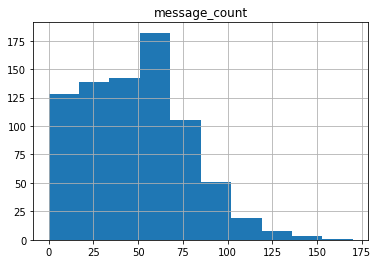

In [42]:
df.pivot_table(index="price", values="message_count").hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f976a398790>]],
      dtype=object)

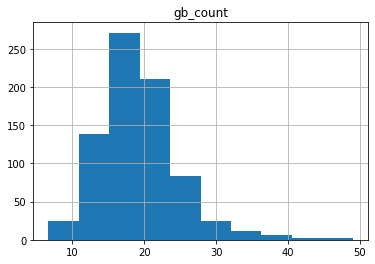

In [43]:
df.pivot_table(index="price", values="gb_count").hist()

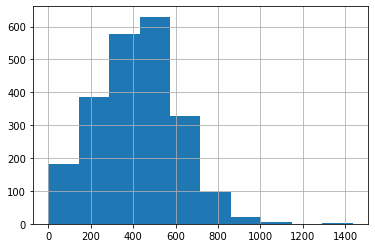

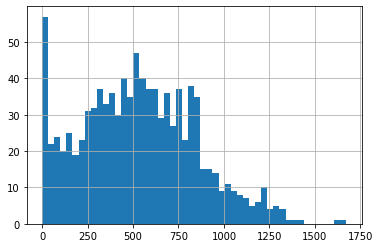

In [44]:
df.query('tariff == "smart"')['ring_length'].hist()#нормальное распределение
plt.show()
df.query('tariff == "ultra"')['ring_length'].hist(bins=50)#похоже на нормальное распределение
plt.show()

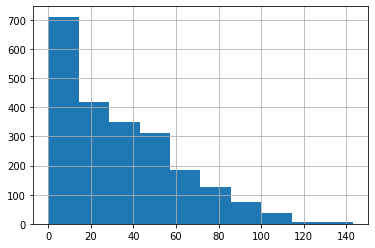

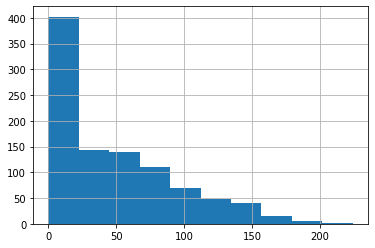

In [45]:
df.query('tariff == "smart"')['message_count'].hist()#явно распределение Пуассона
plt.show()
df.query('tariff == "ultra"')['message_count'].hist()#явно распределение Пуассона
plt.show()

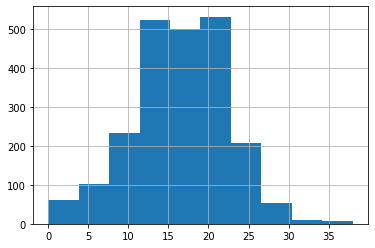

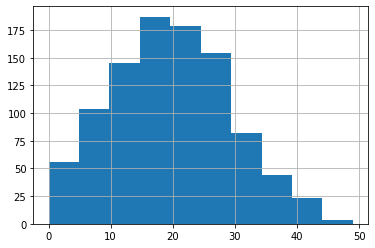

In [46]:
df.query('tariff == "smart"')['gb_count'].hist()#нормальное распределение
plt.show()
df.query('tariff == "ultra"')['gb_count'].hist()#нормальное распределение
plt.show()

<a id="4"></a>
### 4. Проверка гипотез 

**Гипотеза № 1
Средняя выручка пользователей тарифов «Ультра» и «Смарт» различается.
Нулевой гипотезой будет - средние выборок равны, а альтернативной гипотезой будет - средняя выручка пользователей тарифов «Ультра» и «Смарт» различается**

In [47]:
alpha = 0.05
results = st.ttest_ind(df.query('tariff == "smart"')['price'], df.query('tariff == "ultra"')['price'], equal_var = False)
print('p-value:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-value: 1.2190212555992077e-245
Отвергаем нулевую гипотезу


**Гипотеза №2 Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов. Нулевой гипотезой будет - средняя выручка пользователей из Москвы равна средней выручки пользователей других городов, а альтернативной будет - средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов**

In [48]:
moscow = df[df.city == 'Москва']
outer = df[df.city != 'Москва']

In [49]:
alpha = 0.05
results = st.ttest_ind(moscow['price'], outer['price'], equal_var = False)
print('p-value:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-value: 0.48884303879956803
Не получилось отвергнуть нулевую гипотезу


#### Общий вывод
> В результате работы над проектом мы получили таблицу в которой посчитали сколько минут абоненты разговаривают в месяц, сколько отправляют сообщений и как долго пользуются интерентом, так же мы посчитали выручку компании от этих абонентов. Далее мы разделили всех клиентов по тарифным группам и проверили правильность нашей гипотезы.
Как выяснилось средняя прибыль на двух тарифах различается, кроме того мы заметили что количество израсходаванных минут, сообщений и гигабай не сильно отличается на двух тарифах, а стоимость отличается и очень сильно. Поэтому прибыль тарифа УЛЬТРА выше тарифа СМАРТ.
